In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
batch_size = 32
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/...",
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 6000 files belonging to 2 classes.
Using 5400 files for training.


In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/...",
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 6000 files belonging to 2 classes.
Using 600 files for validation.


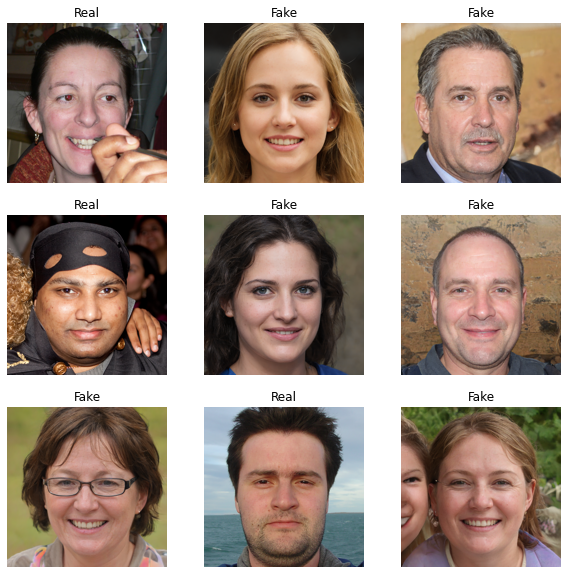

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 19


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

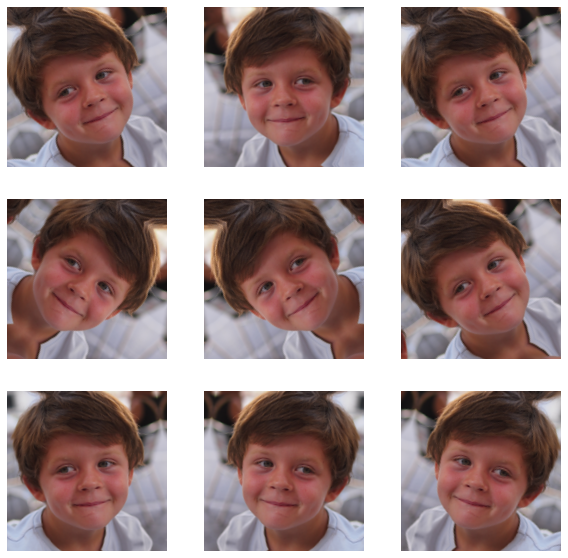

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(160, 160, 3),
    include_top=False,
)  

# Freeze the base_model
base_model.trainable = False


inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Normalize from (0, 255) a (-1, 1)
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

x = norm_layer(x)
norm_layer.set_weights([mean, var])


x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x) 
model = tf.keras.Model(inputs, outputs)

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 160, 160, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
______________________________________________________________

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("saveBefore_at_{epoch}.h5"),
]

epochs = 10
model.fit(train_dataset, epochs=epochs, callbacks=callbacks, validation_data=validation_dataset)

Epoch 1/10
169/169 [==============================] - 1422s 8s/step - loss: 0.5157 - binary_accuracy: 0.7192 - val_loss: 0.3701 - val_binary_accuracy: 0.7867
Epoch 2/10
169/169 [==============================] - 18s 105ms/step - loss: 0.3581 - binary_accuracy: 0.8295 - val_loss: 0.3234 - val_binary_accuracy: 0.8350
Epoch 3/10
169/169 [==============================] - 19s 106ms/step - loss: 0.3461 - binary_accuracy: 0.8370 - val_loss: 0.3038 - val_binary_accuracy: 0.8467
Epoch 4/10
169/169 [==============================] - 19s 106ms/step - loss: 0.3214 - binary_accuracy: 0.8486 - val_loss: 0.2903 - val_binary_accuracy: 0.8683
Epoch 5/10
169/169 [==============================] - 19s 107ms/step - loss: 0.3014 - binary_accuracy: 0.8593 - val_loss: 0.2880 - val_binary_accuracy: 0.8600
Epoch 6/10
169/169 [==============================] - 19s 106ms/step - loss: 0.3025 - binary_accuracy: 0.8559 - val_loss: 0.2881 - val_binary_accuracy: 0.8567
Epoch 7/10
169/169 [===========================

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("saveAfter_at_{epoch}.h5"),
]

epochs = 10
model.fit(train_dataset, epochs=epochs, callbacks=callbacks, validation_data=validation_dataset)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 160, 160, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  